Information about data:

                     ->We have the amazon reviews dataset from kaggle
                     
                     ->Reviews are given for the product
                     
                     ->The features of the data were:
                     
                           Id
                           
                           ProductId- unique identifier for the product
                           
                           UserId- unqiue identifier for the user
                           
                           ProfileName
                           
                           HelpfullnessNumerator- number of users who found the review helpful
                           
                           HelpfulnessDenominator- number of users who indicated whether they 
                           found the review helpful or not
                           
                           Score-rating between 1 and 5
                           
                           Time-timestamp for the review
                           
                           Summary- brief summary of the review
                           
                           Text- text of the review
                       
                     -> Based on the score of the review we review we classify them into positive 
                        and negative
                     
                     Number of reviews: 568,454

                     
                    
                     
                  

objective:

    -> Cleaning the dataset by classifying them into positive and negative reviews based on the 
      rating provided and removing the duplicates
      
    -> Converting the text data to vectors by using Bag of words,Tfidf,word2vec,Average word2vec
    
    -> Applying k-fold cross-validation do determine the best k value having accuracy as the check        measure
    
    -> Here we can use both random based splitting of data or time based splitting of data
    
    -> Since it is the data of reviews they may change overtime due to modifications of products
    
    -> The accurancy which we obtained by random based splitting may change for the future data
    
    -> We can assure about the accurancy obtained in time base splitting for unseen future data 
       also.
    
    -> In this for the first method i am going to do both random based splitting and time based 
       splitting
    
    -> Random based splitting is possible for every dataset, but for time based splitting there 
       should time attribute
    

Importing the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mp
import seaborn as s
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer,CountVectorizer
import sqlite3
import nltk
import string
from sklearn.metrics import accuracy_score,roc_curve,auc,confusion_matrix
from sklearn.cross_validation import train_test_split,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation
from collections import Counter


/Users/vthumati/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


->loading the data and information about the data

-> Shape of the data

-> Dimensionality of the data

-> Attributes if the data

In [2]:
con = sqlite3.connect("database.sqlite")
data = pd.read_sql_query("SELECT * FROM Reviews WHERE Score != 3",con)
print(data.shape)
print(data.ndim)
print(data.columns)

(525814, 10)
2
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


Removing the Duplicates from the data

In [3]:
####function to categorise rating into positive and negatives
def change(n):
    if n>3:
        return 'positive'
    return 'negative'

rating = data['Score']    
####take the ratings
rating = rating.map(change)  
#####apply function change on ratings column
data['Score'] = rating    
####updating the column with positive and negatives
data.head(6)          
##### head with first 6 elements in data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...


Data Cleaning:Removing Duplicates

In [4]:
user = pd.read_sql_query("""SELECT * FROM Reviews WHERE UserId= "AR5J8UI46CURR" ORDER BY ProductId """,con)
print(user)

       Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS

Observation:
    
    -> Here we can see that for the same time span we got five reviews, practically which is not 
       possible
    
    ->This happened because when the user given review for a product it is applied to all the 
       flavors of the product

In [5]:
sorteddata = data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')


In [6]:
finaldata = sorteddata.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)

Information about the modified data:

    -> Shape of the data

    -> Dimensionality of the data

    -> Attributes if the data

    -> Sample of modified data

In [7]:
print(finaldata.shape)
print(finaldata.ndim)
print(finaldata.columns)
print(finaldata.head(5))

(364173, 10)
2
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')
            Id   ProductId          UserId                  ProfileName  \
138706  150524  0006641040   ACITT7DI6IDDL              shari zychinski   
138688  150506  0006641040  A2IW4PEEKO2R0U                        Tracy   
138689  150507  0006641040  A1S4A3IQ2MU7V4        sally sue "sally sue"   
138690  150508  0006641040     AZGXZ2UUK6X  Catherine Hallberg "(Kate)"   
138691  150509  0006641040  A3CMRKGE0P909G                       Teresa   

        HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
138706                     0                       0  positive   939340800   
138688                     1                       1  positive  1194739200   
138689                     1                       1  positive  1191456000   
138690                     1                       1  p

Keeping in mind about the performance capability of the box, here i am taking the subset of the data

In [8]:
finaldata1 = finaldata.sample(n=100000)

Information about the sampled data:

    -> Shape of the data

    -> Dimensionality of the data

    -> Attributes if the data

    -> Sample of modified data

In [9]:
print(finaldata1.shape)
print(finaldata1.ndim)
print(finaldata1.columns)
print(finaldata1.head(5))

(100000, 10)
2
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')
            Id   ProductId          UserId              ProfileName  \
425529  460208  B005BRHVD6    AAU4SEQOA9NE  Ryan Barton "The Knife"   
494547  534658  B0018Q1G94  A3FITKZSOILAJX            Ursula Nemeth   
147114  159580  B000V0H4A8   A5D3JR6T9T53V  Boston Gal "Boston Gal"   
441781  477703  B0029TECEA  A3ONWXEVE56C7G                J. Schick   
276015  299126  B004VB0Q9Y  A2Y5OR28P88B49                 Patricia   

        HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
425529                     1                       1  positive  1305244800   
494547                     0                       0  positive  1346803200   
147114                     1                       1  positive  1326672000   
441781                     8                       9  positive  1256342400   
2

BAG OF WORDS: 
    
    -> RANDOM BASED SPLITTING:
        
        ->SIMPLE CROSS-VALIDATION AND K-FOLD CROSS-VALIDATION:
            
            -> TO FIND THE BEST K-VALUE WITH ACCURANCY AS MEASURE
            

Using Count-Vectorizer to convert the text to vector representation

In [10]:
cv  = CountVectorizer()
countvect = cv.fit_transform(finaldata1['Text'].values)
print(type(countvect))
print(countvect.get_shape())

<class 'scipy.sparse.csr.csr_matrix'>
(100000, 61819)


In [11]:
score = finaldata1['Score']
print(score.shape)

(100000,)


In [12]:
score.head(5)

425529    positive
494547    positive
147114    positive
441781    positive
276015    positive
Name: Score, dtype: object

RANDOM BASED SPLITTING OF DATA:
        
        -> SIMPLE CROSS-VALIDATION


In [13]:
x_1,x_test,y_1,y_test = cross_validation.train_test_split(countvect,score,test_size=0.3,random_state=9)

 Shape of Test and Train dataset:
      
      -> The whole data is divided into training data contains 70% percent of data

      -> 30 % of data for testing

In [14]:
print(x_1.get_shape())
print(x_test.get_shape())
print(y_1.count())
print(y_test.count())


(70000, 61819)
(30000, 61819)
70000
30000


Splitting the test data into test and cross-validation data:
    
    -> Again the training data is divided into 70 and 30 ratio

    -> This 70 % to train and 30 % for cross validation
    

In [15]:
x_train,x_cv,y_train,y_cv = cross_validation.train_test_split(x_1,y_1,test_size=0.3,random_state=8)

In [16]:
print(x_train.get_shape())
print(x_cv.get_shape())
print(y_train.count())
print(y_cv.count())

(49000, 61819)
(21000, 61819)
49000
21000


In [18]:
for i in range(1,30,2):
    clas = KNeighborsClassifier(n_neighbors=i)
    clas.fit(x_train,y_train)
    pred = clas.predict(x_cv)
    acc = accuracy_score(y_cv,pred,normalize=True)*float(100)
    print('the accurate percentage of k = {} is {}'.format(i,acc))

the accurate percentage of k = 1 is 81.66190476190476
the accurate percentage of k = 3 is 84.04761904761905
the accurate percentage of k = 5 is 84.64285714285714
the accurate percentage of k = 7 is 84.63333333333334
the accurate percentage of k = 9 is 84.65238095238095
the accurate percentage of k = 11 is 84.67619047619047
the accurate percentage of k = 13 is 84.63809523809523
the accurate percentage of k = 15 is 84.57619047619048
the accurate percentage of k = 17 is 84.54285714285714
the accurate percentage of k = 19 is 84.4952380952381
the accurate percentage of k = 21 is 84.47619047619047
the accurate percentage of k = 23 is 84.46190476190476
the accurate percentage of k = 25 is 84.42380952380952
the accurate percentage of k = 27 is 84.39047619047619
the accurate percentage of k = 29 is 84.39999999999999


Note:
    
   -> The highest accurancy 84.67 with cross-validation is occured when k = 11

   -> Using the same k-value and testing the accuracy on the test data set

In [22]:
clas = KNeighborsClassifier(n_neighbors = 11)
clas.fit(x_train,y_train)
pred = clas.predict(x_test)
acc = accuracy_score(y_test,pred,normalize=True)*float(100)
print("The accuracy on the test data set when k = {} is {}".format(11,acc))

The accuracy on the test data set when k = 11 is 84.75


Observation:
    
    By using simple cross validation the highest accuracy achieved is 84.75 when k = 11

RANDOM BASED SPLITTING OF DATA:
    
    K-FOLD CROSS VALIDATION

In [17]:
l = list(np.arange(1,30,2))
print(l)


[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]


In [24]:
cross_validation_scores = []
for k in l:
    classif = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(classif,x_train,y_train,cv=10,scoring='accuracy')
    cross_validation_scores.append(score.mean())
    

In [26]:
error = [1 - x for x in cross_validation_scores]
print("Cross Validation Accuracy Scores")
print(cross_validation_scores)
print("errors")
print(error)

Cross Validation Accuracy Scores
[0.8195103131824372, 0.841714120854399, 0.8463265325417131, 0.847489743752176, 0.8471020594378201, 0.8468366491810349, 0.8464489065576387, 0.8462652372455326, 0.8462040502375696, 0.8462244792263423, 0.8459795895868216, 0.8457959452643042, 0.8454489689899611, 0.8453673529932259, 0.8452857286666277]
errors
[0.18048968681756283, 0.158285879145601, 0.15367346745828692, 0.152510256247824, 0.15289794056217987, 0.15316335081896515, 0.15355109344236129, 0.1537347627544674, 0.15379594976243038, 0.15377552077365775, 0.15402041041317838, 0.15420405473569576, 0.15455103101003886, 0.15463264700677415, 0.15471427133337234]


Text(0.5,1,'k vs CV Accuracy')

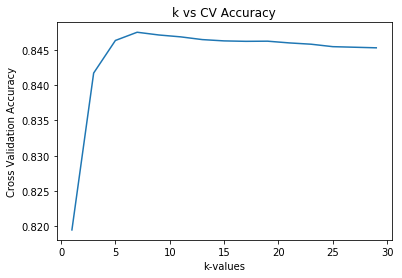

In [27]:
mp.plot(l,cross_validation_scores)
mp.xlabel('k-values')
mp.ylabel('Cross Validation Accuracy')
mp.title("k vs CV Accuracy")

Text(0.5,1,'k vs error')

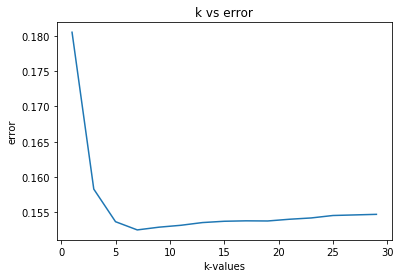

In [28]:
mp.plot(l,error)
mp.xlabel('k-values')
mp.ylabel('error')
mp.title("k vs error")

In [29]:
best_k = l[error.index(min(error))]
print("the best value of k is {}".format(best_k))

the best value of k is 7


Observation:
    
    -> By using k-fold cross validation we got best k value
    
    -> From the plots we can say that error is less at k = 7 when compared with all of them
    
    -> By using k = 7 designing the classifier with the training data

In [30]:
kclas = KNeighborsClassifier(n_neighbors=best_k)
kclas.fit(x_train,y_train)
predi = kclas.predict(x_test)
accur = accuracy_score(y_test,predi,normalize=True)*float(100)
print(accur)

84.83333333333334


Observation:
    
    -> Using the best k value to design the model with train data
    
    -> The accurancy with the test data is 84.83

BAG OF WORDS:
    
    TIME BASED SPLITTING OF DATA:
    
         -> K-FOLD CROSS-VALIDATION:

         -> TO FIND THE BEST K-VALUE WITH ACCURANCY AS MEASURE

    
    

In order to perform this we have sort the data based on time

In [18]:
sorted_count_vect = finaldata1.sort_values("Time",axis=0,ascending=True,kind='quicksort',na_position='last',inplace=False)

Information about the sorted data:

    -> Shape of the data

    -> Dimensionality of the data

    -> Attributes if the data

    -> Sample of modified data

In [19]:
print(sorted_count_vect.shape)
print(sorted_count_vect.ndim)
print(sorted_count_vect.columns)
print(sorted_count_vect.head(5))

(100000, 10)
2
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')
            Id   ProductId          UserId       ProfileName  \
417839  451856  B00004CXX9   AIUWLEQ1ADEG5  Elizabeth Medina   
346055  374359  B00004CI84  A344SMIA5JECGM   Vincent P. Ross   
70688    76882  B00002N8SM  A32DW342WBJ6BX       Buttersugar   
346094  374400  B00004CI84  A2DEE7F9XKP3ZR            jerome   
138017  149789  B00004S1C6  A1KXONFPU2XQ5K  Stephanie Manley   

        HelpfulnessNumerator  HelpfulnessDenominator     Score       Time  \
417839                     0                       0  positive  944092800   
346055                     1                       2  positive  944438400   
70688                      0                       0  positive  948672000   
346094                     0                       3  positive  959990400   
138017                    26                    

In [20]:
count_vector = CountVectorizer()


In [21]:
cvr  = count_vector.fit_transform(sorted_count_vect['Text'].values)

In [22]:
score = sorted_count_vect["Score"]

In [23]:
print(cvr.shape)
print(score.shape)

(100000, 61819)
(100000,)


In [24]:
x_train = cvr[0:70000]
x_test = cvr[70000:100000]
y_train = score[0:70000]
y_test = score[70000:100000]

Splitting the sampled data into test and train:

-> Training data contains 70 percent of data

-> Test data contains 30 percent of data

In [25]:

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(70000, 61819)
(30000, 61819)
(70000,)
(30000,)


TIME BASED SPLITTING :

            K-FOLD CROSS VALIDATION

In [26]:
l = list(np.arange(1,30,2))
print(l)


[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]


In [54]:
cross_validation_scores = []
for k in l:
    classif = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(classif,x_train,y_train,cv=10,scoring='accuracy')
    cross_validation_scores.append(score.mean())
    

In [55]:
error = [1 - x for x in cross_validation_scores]
print("Cross Validation Accuracy Scores")
print(cross_validation_scores)
print("errors")
print(error)

Cross Validation Accuracy Scores
[0.8229853780201098, 0.8476284336250701, 0.8520285439189499, 0.853171507207582, 0.8533857908854243, 0.8530286500618093, 0.8529143806717221, 0.8525715153586024, 0.8523857500486887, 0.8521714377994171, 0.8521000235122453, 0.8514714561524788, 0.8513571500276969, 0.8512428520661807, 0.8513285663536442]
errors
[0.17701462197989015, 0.15237156637492988, 0.1479714560810501, 0.14682849279241805, 0.14661420911457568, 0.14697134993819072, 0.1470856193282779, 0.14742848464139757, 0.14761424995131134, 0.14782856220058294, 0.14789997648775466, 0.14852854384752123, 0.14864284997230315, 0.14875714793381933, 0.14867143364635582]


Text(0.5,1,'k vs CV Accuracy')

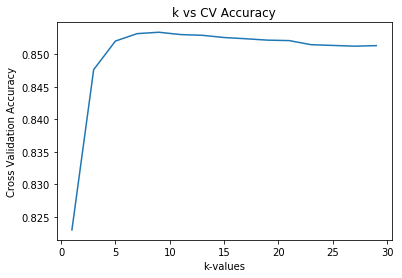

In [56]:
mp.plot(l,cross_validation_scores)
mp.xlabel('k-values')
mp.ylabel('Cross Validation Accuracy')
mp.title("k vs CV Accuracy")

Text(0.5,1,'k vs error')

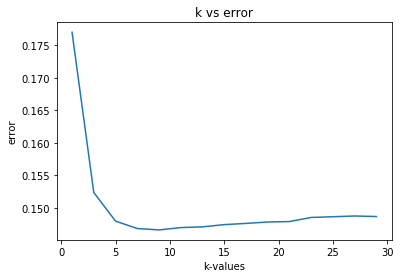

In [57]:
mp.plot(l,error)
mp.xlabel('k-values')
mp.ylabel('error')
mp.title("k vs error")

In [58]:
best_k = l[error.index(min(error))]
print("the best value of k is {}".format(best_k))

the best value of k is 9


Observation:
    
    -> By using k-fold cross validation we got best k value as 9
    
    -> From the plots we can say that error is less at k = 9 when compared with all of them
    
    -> By using k = 9 designing the classifier with the training data

In [59]:
kclas = KNeighborsClassifier(n_neighbors=best_k)
kclas.fit(x_train,y_train)
predi = kclas.predict(x_test)
accur = accuracy_score(y_test,predi,normalize=True)*float(100)
print(accur)

83.22666666666667


Observation:
    
    -> Using the best k value to design the model with train data
    
    -> The accurancy with the test data is 83.2266

TFIDF:

TIME BASED SPLITTING OF DATA:

     -> K-FOLD CROSS-VALIDATION:

     -> TO FIND THE BEST K-VALUE WITH ACCURANCY AS MEASURE

In [27]:
tfidf_data = finaldata1.sort_values("Time",axis=0,ascending=True,kind='quicksort',na_position='last',inplace=False)

Information about the sorted data:

    -> Shape of the data

    -> Dimensionality of the data

    -> Attributes if the data

    -> Sample of modified data

In [28]:
print(tfidf_data.shape)
print(tfidf_data.ndim)
print(tfidf_data.columns)
print(tfidf_data.head(5))

(100000, 10)
2
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')
            Id   ProductId          UserId       ProfileName  \
417839  451856  B00004CXX9   AIUWLEQ1ADEG5  Elizabeth Medina   
346055  374359  B00004CI84  A344SMIA5JECGM   Vincent P. Ross   
70688    76882  B00002N8SM  A32DW342WBJ6BX       Buttersugar   
346094  374400  B00004CI84  A2DEE7F9XKP3ZR            jerome   
138017  149789  B00004S1C6  A1KXONFPU2XQ5K  Stephanie Manley   

        HelpfulnessNumerator  HelpfulnessDenominator     Score       Time  \
417839                     0                       0  positive  944092800   
346055                     1                       2  positive  944438400   
70688                      0                       0  positive  948672000   
346094                     0                       3  positive  959990400   
138017                    26                    

In [29]:
tfid_vect = TfidfVectorizer(ngram_range=(1,2))

In [30]:
tfid_vect_data = tfid_vect.fit_transform(tfidf_data["Text"].values)

In [31]:
print(tfid_vect_data.shape)
print(tfidf_data["Score"].shape)

(100000, 1287433)
(100000,)


Splitting the sampled data into test and train:

-> Training data contains 70 percent of data

-> Test data contains 30 percent of data

In [32]:
x_train = tfid_vect_data[0:70000]
x_test = tfid_vect_data[70000:100000]
y_train = tfidf_data['Score'][0:70000]
y_test = tfidf_data['Score'][70000:100000]


In [33]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(70000, 1287433)
(30000, 1287433)
(70000,)
(30000,)


TIME BASED SPLITTING:
    
    K-FOLD CROSS VALIDATION

In [34]:
l = list(np.arange(1,30,2))
print(l)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]


In [71]:
cross_validation_scores = []
for k in l:
    classif = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(classif,x_train,y_train,cv=10,scoring='accuracy')
    cross_validation_scores.append(score.mean())
    

In [72]:
error = [1 - x for x in cross_validation_scores]
print("Cross Validation Accuracy Scores")
print(cross_validation_scores)
print("errors")
print(error)

Cross Validation Accuracy Scores
[0.8475139805615098, 0.8578856093446042, 0.863228519657725, 0.8653428870478141, 0.8665142789084547, 0.867514401377845, 0.8669716176932983, 0.866400127885717, 0.8660715829810528, 0.8658715625688075, 0.8651001707163302, 0.864414480906418, 0.8641001584510237, 0.864042946204958, 0.8634000992530633]
errors
[0.15248601943849016, 0.14211439065539577, 0.13677148034227504, 0.13465711295218585, 0.13348572109154533, 0.13248559862215503, 0.13302838230670166, 0.13359987211428304, 0.1339284170189472, 0.13412843743119252, 0.13489982928366984, 0.13558551909358196, 0.13589984154897627, 0.13595705379504197, 0.13659990074693673]


Text(0.5,1,'k vs CV Accuracy')

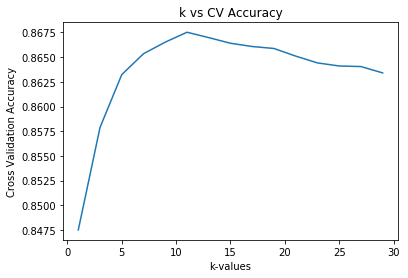

In [73]:
mp.plot(l,cross_validation_scores)
mp.xlabel('k-values')
mp.ylabel('Cross Validation Accuracy')
mp.title("k vs CV Accuracy")

Text(0.5,1,'k vs Error')

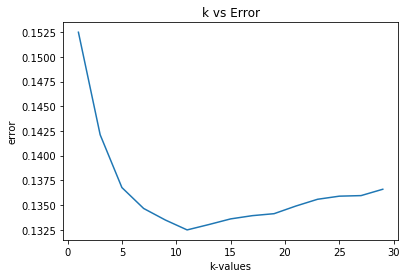

In [77]:
mp.plot(l,error)
mp.xlabel('k-values')
mp.ylabel('error')
mp.title("k vs Error")

In [78]:
best_k = l[error.index(min(error))]
print("the best value of k is {}".format(best_k))

the best value of k is 11


Observation:
    
    -> By using k-fold cross validation we got best k value as 11
    
    -> From the plots we can say that error is less at k = 11 when compared with all of them
    
    -> By using k = 11 designing the classifier with the training data

In [79]:
kclas = KNeighborsClassifier(n_neighbors=best_k)
kclas.fit(x_train,y_train)
predi = kclas.predict(x_test)
accur = accuracy_score(y_test,predi,normalize=True)*float(100)
print(accur)

84.98333333333333


Observation:

    -> Using the best k value to design the model with train data
    
    -> The accurancy with the test data is 84.9833

CONSTRUCTING VECTOR REPRESENTATION OF EACH IN THE DATA BY USING WORD2VEC

In [35]:
import gensim
from gensim.models import word2vec

-> Importing the required libraries

-> Functions to clean the sentences

-> Constructing the word2vec from the sample subset data

In [36]:
import re
def cleanhtml(sentence):
    clean = re.compile("<.*?>")
    cleantext = re.sub(clean," ",sentence)
    return cleantext
def cleanpunct(sentence):
    cleanr = re.sub(r"[?|!|\|'|#|.|,|)|(|/]",r' ',sentence)
    return cleanr

In [37]:
sorted_w2vec = finaldata1.sort_values("Time",axis=0,ascending=True,kind='quicksort',na_position='last',inplace=False)

Information about the sorted data:

    -> Shape of the data

    -> Dimensionality of the data

    -> Attributes if the data

    -> Sample of modified data

In [38]:
print(sorted_w2vec.shape)
print(sorted_w2vec.ndim)
print(sorted_w2vec.columns)
print(sorted_w2vec.head(5))

(100000, 10)
2
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')
            Id   ProductId          UserId       ProfileName  \
417839  451856  B00004CXX9   AIUWLEQ1ADEG5  Elizabeth Medina   
346055  374359  B00004CI84  A344SMIA5JECGM   Vincent P. Ross   
70688    76882  B00002N8SM  A32DW342WBJ6BX       Buttersugar   
346094  374400  B00004CI84  A2DEE7F9XKP3ZR            jerome   
138017  149789  B00004S1C6  A1KXONFPU2XQ5K  Stephanie Manley   

        HelpfulnessNumerator  HelpfulnessDenominator     Score       Time  \
417839                     0                       0  positive  944092800   
346055                     1                       2  positive  944438400   
70688                      0                       0  positive  948672000   
346094                     0                       3  positive  959990400   
138017                    26                    

In [39]:
i=0
sentences_list=[]
for sent in sorted_w2vec['Text'].values:
    filtered_sentences = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleanedwords in cleanpunct(w).split():
            if(cleanedwords.isalpha()):
                filtered_sentences.append(cleanedwords.lower())
    sentences_list.append(filtered_sentences)   
    
    

In [40]:
print(len(sentences_list))
print(type(sentences_list))

100000
<class 'list'>


In [41]:
w2vmodel = gensim.models.Word2Vec(sentences_list,min_count=4,size=40,workers=4)

-> Most similar word

-> Similarity between the words

-> Dimensionality representation of a word

In [42]:
print(w2vmodel.most_similar("hello"))
print(w2vmodel.similarity("hello",'hi'))
print(w2vmodel.wv['hello'])

[('mickey', 0.7368489503860474), ('anyhow', 0.7226568460464478), ('focaccia', 0.709900975227356), ('fern', 0.7098590731620789), ('mike', 0.699766993522644), ('boomer', 0.6946572661399841), ('themed', 0.6860719919204712), ('merry', 0.6846867799758911), ('claxton', 0.6834409236907959), ('samoas', 0.6817569732666016)]
0.5446572411054558
[ 0.29999846 -0.19882171 -0.41949722 -0.4891025  -0.3457285   0.03067495
  0.33179036  0.11951371 -0.3910432  -0.33136272 -0.08102001  0.09156115
  0.2493193   0.2969718   0.23660749 -0.362925   -0.38329345  0.02786745
  0.2396555  -0.12413767  0.32540685 -0.04338589  0.27390665  0.233951
 -0.24852224  0.18082564  0.3852502   0.25250012 -0.04117521  0.1665598
 -0.1021607   0.06984844  0.10276769  0.21571645  0.4212314   0.19228005
  0.01020537  0.06221204 -0.18181211  0.15039672]


/Users/vthumati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/Users/vthumati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


Observation:
    
    -> We have constructed the vector representation of each word
    
    -> Using this model to construct vector representation of each sentence in average word2vec and tfidf-word2vec

AVERAGE WORD2VEC

    -> Here i am using the word2vec model to construct vector representation of each sentence

    -> Sorting the data based on the time

In [43]:

sent_vectors = []
for sent in sentences_list: 
    sent_vec = np.zeros(40) 
    cnt=0
    for word in sent:
        try:
            vec = w2vmodel.wv[word]
            sent_vec += vec
            cnt += 1
        except:
            pass
    sent_vec /= cnt
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[88888]))

100000
40


In [44]:
np.isnan(sent_vectors).any()

False

In [45]:
type(sent_vectors)

list

In [46]:
sent_vectors = np.nan_to_num(sent_vectors)

In [47]:
type(sent_vectors)

numpy.ndarray

In [48]:
sent_vectors.shape

(100000, 40)

In [49]:
x_train = sent_vectors[0:70000]
x_test = sent_vectors[70000:100000]
y_train = sorted_w2vec['Score'][0:70000]
y_test = sorted_w2vec['Score'][70000:100000]

In [50]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(70000, 40)
(30000, 40)
(70000,)
(30000,)


In [51]:
print(l)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]


In [52]:
from sklearn.cross_validation import cross_val_score

In [53]:
cross_validation_scores = []
for k in l:
    classif = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(classif,x_train,y_train,cv=10,scoring='accuracy')
    cross_validation_scores.append(score.mean())
    

In [54]:
error = [1 - x for x in cross_validation_scores]
print("Cross Validation Accuracy Scores")
print(cross_validation_scores)
print("errors")
print(error)

Cross Validation Accuracy Scores
[0.8293284544422717, 0.8614428912836741, 0.8692571606994173, 0.8718571300880464, 0.873614285205831, 0.873585701530612, 0.8744857484731785, 0.8742428852075808, 0.8747000239784262, 0.8746142688775507, 0.8741142811218658, 0.8743285770411079, 0.8747142913268224, 0.8742857015282797, 0.8737857035705536]
errors
[0.17067154555772834, 0.13855710871632587, 0.13074283930058272, 0.12814286991195356, 0.12638571479416905, 0.126414298469388, 0.1255142515268215, 0.12575711479241924, 0.12529997602157383, 0.12538573112244933, 0.12588571887813416, 0.1256714229588921, 0.12528570867317756, 0.12571429847172033, 0.12621429642944637]


Text(0.5,1,'k vs CV Accuracy')

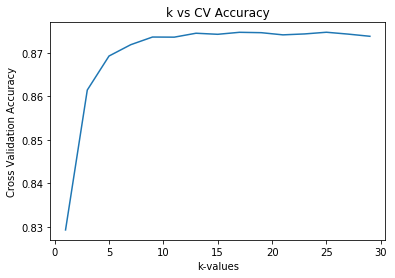

In [55]:
mp.plot(l,cross_validation_scores)
mp.xlabel('k-values')
mp.ylabel('Cross Validation Accuracy')
mp.title("k vs CV Accuracy")

Text(0.5,1,'k vs Error')

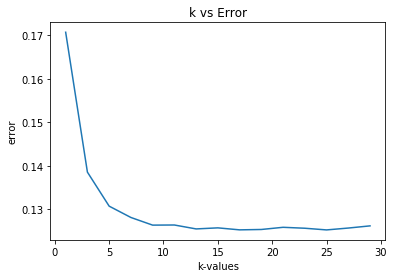

In [56]:
mp.plot(l,error)
mp.xlabel('k-values')
mp.ylabel('error')
mp.title("k vs Error")

In [57]:
best_k = l[error.index(min(error))]
print("the best value of k is {}".format(best_k))

the best value of k is 25


Observation:
    
    -> By using k-fold cross validation we got best k value as 25
    
    -> From the plots we can say that error is less at k = 25 when compared with all of them
    
    -> By using k = 25 designing the classifier with the training data

In [58]:
kclas = KNeighborsClassifier(n_neighbors=best_k)
kclas.fit(x_train,y_train)
predi = kclas.predict(x_test)
accur = accuracy_score(y_test,predi,normalize=True)*float(100)
print(accur)

85.71666666666667


Observation:

    -> Using the best k value to design the model with train data
    
    -> The accurancy with the test data is 85.71

TFIDF-WORD2VEC:
    
    Here i am using the TFIDF-WORD2VEC eith the help of word2vec model to construct vector represenation of each sentence

In [53]:

tfidf_feat = tfid_vect.get_feature_names() 

tfidf_sent_vectors = []

row=0
for sent in sentences_list: 
    sent_vec = np.zeros(40) 
    sum =0
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
           
            tfidf = tfid_vect_data[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            sum += tf_idf
        except:
            pass
    sent_vec /= sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    

    

/Users/vthumati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


In [54]:
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[99999]))

100000
40


In [55]:
type(tfidf_sent_vectors)

list

In [56]:
np.isnan(tfidf_sent_vectors).any()

True

In [57]:
tfidf_sent_vectors = np.nan_to_num(tfidf_sent_vectors)

In [58]:
np.isnan(tfidf_sent_vectors).any()

False

In [60]:
x_train = tfidf_sent_vectors[0:70000]
x_test = tfidf_sent_vectors[70000:]
y_train = sorted_w2vec['Score'][0:70000]
y_test = sorted_w2vec['Score'][70000:]

In [62]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(70000, 40)
(30000, 40)
(70000,)
(30000,)


In [63]:
print(l)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]


In [64]:
from sklearn.cross_validation import cross_val_score

In [65]:
cross_validation_scores = []
for k in l:
    classif = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(classif,x_train,y_train,cv=10,scoring='accuracy')
    cross_validation_scores.append(score.mean())
    

In [66]:
error = [1 - x for x in cross_validation_scores]
print("Cross Validation Accuracy Scores")
print(cross_validation_scores)
print("errors")
print(error)

Cross Validation Accuracy Scores
[0.8506285771533528, 0.8506285771533528, 0.8506285771533528, 0.8506285771533528, 0.8506285771533528, 0.8506285771533528, 0.8506285771533528, 0.8506285771533528, 0.8506285771533528, 0.8506285771533528, 0.8506285771533528, 0.8506285771533528, 0.8506285771533528, 0.8506285771533528, 0.8506285771533528]
errors
[0.14937142284664717, 0.14937142284664717, 0.14937142284664717, 0.14937142284664717, 0.14937142284664717, 0.14937142284664717, 0.14937142284664717, 0.14937142284664717, 0.14937142284664717, 0.14937142284664717, 0.14937142284664717, 0.14937142284664717, 0.14937142284664717, 0.14937142284664717, 0.14937142284664717]


Text(0.5,1,'k vs CV Accuracy')

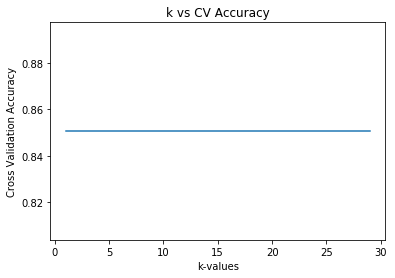

In [67]:
mp.plot(l,cross_validation_scores)
mp.xlabel('k-values')
mp.ylabel('Cross Validation Accuracy')
mp.title("k vs CV Accuracy")

Text(0.5,1,'k vs Error')

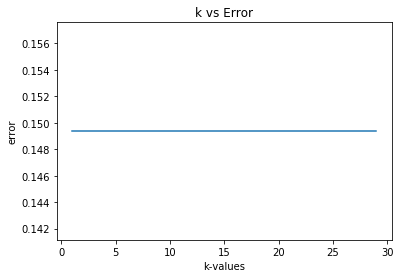

In [68]:
mp.plot(l,error)
mp.xlabel('k-values')
mp.ylabel('error')
mp.title("k vs Error")

In [69]:
best_k = l[error.index(min(error))]
print("the best value of k is {}".format(best_k))

the best value of k is 1


In [70]:
kclas = KNeighborsClassifier(n_neighbors=best_k)
kclas.fit(x_train,y_train)
predi = kclas.predict(x_test)
accur = accuracy_score(y_test,predi,normalize=True)*float(100)
print(accur)

82.47


 Observation:

    -> Using the best k value which is 1 to design the model with train data
    
    -> The accurancy with the test data is 82.47

CONCLUSION:
    
    RANDOM BASED SPLITTING:
        
        -> THIS IS PERFORMED ONLY ON BAG OF WORDS TECHNIQUE
        
        -> BOTH SIMPLE CROSS VALIDATION AND 10-FOLD CROSS VALIDATION ARE PERFORMED ON THIS 
           TECHNIQUE
        
        -> IN SIMPLE CROSS VALIDATION THE BEST K - VALUE IS 11 AND THE ACCURACY IS 84.67
        
        -> IN 10-FOLD CROSS VALIDATION THE BEST K - VALUE IS 7 AND THE ACCURACY IS 84.83
        
    TIME BASED SPLITTING:
        
        -> THIS IS PERFORMED ON BAG OF WORDS, TFIDF, AVERAGE WORD2VEC
        
        USING 10 - FOLD CROSS VALIDATION:
            
            BAG OF WORDS:
                
                -> THE BEST K - VALUE IS 9 AND THE ACCURANCY IS 83.22
                
            TFIDF:
                
                -> THE BEST K - VALUE IS 11 AND THE ACCURACY IS 84.98
                
            AVERAGE WORD2VEC:
                
                -> THE BEST K - VALUE IS 25 AND THE ACCURACY IS 85.71
                
            TFIDF-WORD2VEC:
                
                -> THE BEST K - VALUE IS 1 AND ACCURACY IS 82.47
                